In [18]:
%pip install torch torchvision
%pip install umap-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.manifold import TSNE
import umap.umap_ as umap
import re
import numpy as np
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as T
from PIL import ImageDraw

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
# from pathlib import Path
# import shutil

# # === CONFIGURE THESE PATHS ===
# train_src_dirs = [
#     Path("/datax/scratch/jliang/iridium_train"),
#     Path("/datax/scratch/jliang/s154_train"),
# ]
# train_dst = Path("/datax/scratch/jliang/iridium_s154_train")

# val_src_dirs = [
#     Path("/datax/scratch/jliang/iridium_val"),
#     Path("/datax/scratch/jliang/s154_val"),
# ]
# val_dst = Path("/datax/scratch/jliang/iridium_s154_val")
# # =============================

# # Make sure the destinations exist
# train_dst.mkdir(parents=True, exist_ok=True)
# val_dst.mkdir(parents=True, exist_ok=True)

# # File extensions to consider “images”
# IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp"}

# def merge_folders(src_dirs, dst_folder, exts):
#     """
#     Copy every image from each folder in src_dirs into dst_folder,
#     but skip any filename you’ve already copied.
#     """
#     seen = set()
#     for src in src_dirs:
#         for path in src.rglob("*"):
#             if not path.is_file(): 
#                 continue
#             if path.suffix.lower() not in exts:
#                 continue

#             name = path.name
#             if name in seen:
#                 # we've already copied a file with this name → skip
#                 continue

#             shutil.copy2(path, dst_folder / name)
#             seen.add(name)

# # Merge train
# merge_folders(train_src_dirs, train_dst, IMAGE_EXTS)
# print(f"Train merge complete: {len(list(train_dst.iterdir()))} files in {train_dst!r}")

# # Merge val
# merge_folders(val_src_dirs, val_dst, IMAGE_EXTS)
# print(f"Val   merge complete: {len(list(val_dst.iterdir()))} files in {val_dst!r}")



In [20]:
# ─── Hyperparameters ──────────────────────────────────────────────────────
IMAGE_SIZE     = 224
IMAGE_CHANNELS = 3
LATENT_DIM     = 32
BATCH_SIZE     = 32
LR             = 1e-4
EPOCHS         = 20
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_IMG_DIR = '/datax/scratch/jliang/vae_set/train/images'
VAL_IMG_DIR   = '/datax/scratch/jliang/vae_set/val/images'
TRAIN_LBL_DIR = '/datax/scratch/jliang/vae_set/train/labels'
VAL_LBL_DIR   = '/datax/scratch/jliang/vae_set/val/labels'
IMG_SIZE = (224, 224)

In [21]:
class YoloMaskDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size, transform=None):
        # … your existing __init__ up through building self.images/self.labels …
        self.images = sorted(glob(os.path.join(images_dir, "*.*")))
        self.labels = [
            os.path.join(labels_dir, os.path.splitext(os.path.basename(p))[0] + ".txt")
            for p in self.images
        ]
        self.transform = transform or T.Compose([
            T.Resize(img_size),
            T.ToTensor(),
        ])
        # optionally: compute global min/max f to normalize later
        freqs = []
        pat = re.compile(r"_f_(?P<fs>[\d\.]+)_(?P<fe>[\d\.]+)")
        for p in self.images:
            m = pat.search(os.path.basename(p))
            if m:
                freqs += [float(m.group("fs").rstrip(".")), float(m.group("fe").rstrip("."))]
        self.fmin, self.fmax = min(freqs), max(freqs)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.labels[idx]

        # — load image & mask (unchanged) —
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        mask = Image.new("L", (W, H), 0)
        draw = ImageDraw.Draw(mask)
        with open(lbl_path) as f:
            for line in f:
                _, xc, yc, w, h = line.strip().split()
                xc, yc, w, h = map(float, (xc, yc, w, h))
                x0 = (xc - w/2) * W
                y0 = (yc - h/2) * H
                x1 = (xc + w/2) * W
                y1 = (yc + h/2) * H
                draw.rectangle([x0, y0, x1, y1], fill=1)

        img_t  = self.transform(img)
        mask_t = self.transform(mask).float()

        # — robustly parse f_start, f_end from filename —
        fname = os.path.basename(img_path)
        name_no_ext, _ = os.path.splitext(fname)
        try:
            # everything after "_f_":
            freqs_str = name_no_ext.split("_f_")[1]
            # split into two parts only
            fstart_str, fend_str = freqs_str.split("_", 1)
            # strip any trailing dots (e.g. "1539.5536." → "1539.5536")
            fstart_str = fstart_str.rstrip(".")
            fend_str   = fend_str.rstrip(".")
            f_start = float(fstart_str)
            f_end   = float(fend_str)
        except Exception as e:
            raise ValueError(f"Could not parse f_start/f_end from '{fname}'") from e

        # — normalize into [0,1], if desired —
        norm_fs = (f_start - self.fmin) / (self.fmax - self.fmin)
        norm_fe = (f_end   - self.fmin) / (self.fmax - self.fmin)
        cond = torch.tensor([norm_fs, norm_fe], dtype=torch.float32)

        return img_t, mask_t

In [22]:
# # ─── Custom Dataset for YOLO Cropped Boxes ─────────────────────────────────
# class YOLOCropDataset(Dataset):
#     def __init__(self, image_dir, label_dir, transform=None):
#         self.samples = []
#         self.transform = transform
#         for img_path in sorted(glob.glob(os.path.join(image_dir, "*.png"))):
#             base = os.path.splitext(os.path.basename(img_path))[0]
#             txt_path = os.path.join(label_dir, base + ".txt")
#             if not os.path.exists(txt_path):
#                 continue
#             img = Image.open(img_path)
#             W, H = img.size
#             with open(txt_path) as f:
#                 for line in f:
#                     parts = line.strip().split()
#                     if len(parts) < 5:
#                         continue
#                     _, x_c, y_c, w, h = parts
#                     x_c, y_c, w, h = map(float, (x_c, y_c, w, h))
#                     x0 = int((x_c - w/2) * W)
#                     y0 = int((y_c - h/2) * H)
#                     x1 = int((x_c + w/2) * W)
#                     y1 = int((y_c + h/2) * H)
#                     self.samples.append((img_path, (x0, y0, x1, y1)))
#         if len(self.samples) == 0:
#             raise RuntimeError("No YOLO crops found. Check image_dir/label_dir.")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         img_path, box = self.samples[idx]
#         img = Image.open(img_path).convert("RGB")
#         crop = img.crop(box)
#         if self.transform:
#             crop = self.transform(crop)
#         return crop, img_path

# class YOLOCropDatasetWithPath(YOLOCropDataset):
#     def __getitem__(self, idx):
#         img_path, box = self.samples[idx]
#         img = Image.open(img_path).convert("RGB")
#         crop = img.crop(box)
#         if self.transform:
#             crop = self.transform(crop)
#         return crop, img_path
    
# # ─── Transforms ────────────────────────────────────────────────────────────
# transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
# ])

# # ─── Instantiate Datasets & Loaders ───────────────────────────────────────
# train_dataset = YOLOCropDataset("/datax/scratch/jliang/dataset_final_small/train/images", "/datax/scratch/jliang/dataset_final_small/train/labels", transform)
# test_dataset  = YOLOCropDataset("/datax/scratch/jliang/dataset_final_small/val/images", "/datax/scratch/jliang/dataset_final_small/val/labels", transform)
# train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
# test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
# full_ds = YOLOCropDatasetWithPath(
#     "/datax/scratch/jliang/dataset_final_small/train/images", "/datax/scratch/jliang/dataset_final_small/train/labels", transform
# )
# full_dl = DataLoader(full_ds, batch_size=64, shuffle=False, num_workers=4)


In [23]:
# class MaCVAE(nn.Module):
#     def __init__(self, in_ch=3, latent_dim=LATENT_DIM, beta=1.5, cond_dim=2):
#         super().__init__()
#         # Encoder CNN
#         channels = [16, 32, 16, 32, 64, 128, 64, 128]
#         layers = []
#         c_in = in_ch
#         for c_out in channels:
#             layers += [
#                 nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1),
#                 nn.ReLU(inplace=True)
#             ]
#             c_in = c_out
#         self.encoder_cnn = nn.Sequential(*layers)

#         # Compute flattened dimension
#         with torch.no_grad():
#             x0 = torch.zeros(1, in_ch, IMAGE_SIZE, IMAGE_SIZE)
#             flat_dim = self.encoder_cnn(x0).numel()

#         # Bottleneck layers (conditional)
#         self.fc_mu     = nn.Linear(flat_dim + cond_dim, latent_dim)
#         self.fc_logvar = nn.Linear(flat_dim + cond_dim, latent_dim)

#         # Decoder fc (conditional)
#         self.fc_dec = nn.Linear(latent_dim + cond_dim, flat_dim)

#         # Decoder CNN transpose
#         deconv = []
#         c_in = channels[-1]
#         for c_out in reversed(channels[:-1]):
#             deconv += [
#                 nn.ConvTranspose2d(c_in, c_out, 3, 2, 1, output_padding=1),
#                 nn.ReLU(inplace=True)
#             ]
#             c_in = c_out
#         deconv.append(nn.ConvTranspose2d(c_in, in_ch, 3, 2, 1, output_padding=1))
#         self.decoder_cnn = nn.Sequential(*deconv)

#         self.beta = beta

#     def encode(self, x, cond):
#         h = self.encoder_cnn(x).flatten(1)
#         h = torch.cat([h, cond], dim=1)
#         return self.fc_mu(h), self.fc_logvar(h)

#     def reparam(self, mu, logvar):
#         sigma = (0.5 * logvar).exp()
#         return mu + sigma * torch.randn_like(sigma)

#     def decode(self, z, cond):
#         zc = torch.cat([z, cond], dim=1)
#         h = self.fc_dec(zc).view(z.size(0), -1, 1, 1)
#         out = self.decoder_cnn(h)
#         out = F.interpolate(
#             out,
#             size=(IMAGE_SIZE, IMAGE_SIZE),
#             mode="bilinear",
#             align_corners=False
#         )
#         return out

#     def forward(self, x, cond):
#         mu, logvar = self.encode(x, cond)
#         z = self.reparam(mu, logvar)
#         recon = self.decode(z, cond)
#         return recon, mu, logvar

#     def loss(self, recon, x, mu, logvar):
#         rec = F.mse_loss(recon, x, reduction='mean')
#         kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
#         return rec + self.beta * kld

In [24]:
# class MaVAE(nn.Module):
#     def __init__(self, in_ch=3, latent_dim=8, beta=1.5):
#         super().__init__()
#         layers = []
#         # 8 conv layers: two reps of [16→32→64→128]
#         channels = [16,32,16,32,64,128,64,128]
#         c_in = in_ch
#         for c_out in channels:
#             layers += [nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1),
#                        nn.ReLU(inplace=True)]
#             c_in = c_out
#         self.encoder_cnn = nn.Sequential(*layers)
#         # compute flattened dim
#         with torch.no_grad():
#             x = torch.zeros(1, in_ch, IMAGE_SIZE, IMAGE_SIZE)
#             flat_dim = self.encoder_cnn(x).numel()
#         # bottleneck
#         self.fc_mu     = nn.Linear(flat_dim, latent_dim)
#         self.fc_logvar = nn.Linear(flat_dim, latent_dim)
#         # decoder
#         self.fc_dec    = nn.Linear(latent_dim, flat_dim)
#         # mirror decoder conv-transpose stack
#         deconv_layers = []
#         for c_out in reversed(channels[:-1]):
#             deconv_layers += [
#               nn.ConvTranspose2d(c_in, c_out, 3, 2, 1, output_padding=1),
#               nn.ReLU(inplace=True)
#             ]
#             c_in = c_out
#         deconv_layers.append(nn.ConvTranspose2d(c_in, in_ch, 3, 2, 1, output_padding=1))
#         self.decoder_cnn = nn.Sequential(*deconv_layers)
#         self.beta = beta

#     def encode(self, x):
#         h = self.encoder_cnn(x).flatten(1)
#         return self.fc_mu(h), self.fc_logvar(h)

#     def reparam(self, mu, log_sigma):
#         sigma = (0.5*log_sigma).exp()
#         return mu + sigma*torch.randn_like(sigma)

#     def decode(self, z):
#         h   = self.fc_dec(z).view(z.size(0), -1, 1, 1)
#         out = self.decoder_cnn(h)                # currently [B, 3, 256,256]
#         out = F.interpolate(
#             out,
#             size=(IMAGE_SIZE, IMAGE_SIZE),
#             mode="bilinear",
#             align_corners=False
#         )                                        # now [B, 3, 224,224]
#         return out

#     def forward(self, x):
#         mu, log_sigma = self.encode(x)
#         z       = self.reparam(mu, log_sigma)
#         recon   = self.decode(z)
#         return recon, mu, log_sigma

#     def loss(self, recon, x, mu, log_sigma):
#         rec = F.mse_loss(recon, x, reduction='mean')
#         kld = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp()) / x.size(0)
#         return rec + self.beta * kld


In [25]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- assuming these are already defined somewhere above: ---
# DATA_DIR, TRAIN_IMG_DIR, TRAIN_LBL_DIR, VAL_IMG_DIR, VAL_LBL_DIR
# IMG_SIZE, BATCH_SIZE, LR, DEVICE, model (MaCVAE instance)

# 1) Datasets + DataLoaders
train_ds = YoloMaskDataset(
    TRAIN_IMG_DIR,
    TRAIN_LBL_DIR,
    IMG_SIZE,
    transform=T.Compose([
        T.Resize(IMG_SIZE),
        T.ToTensor(),
    ])
)
val_ds = YoloMaskDataset(
    VAL_IMG_DIR,
    VAL_LBL_DIR,
    IMG_SIZE,
    transform=T.Compose([
        T.Resize(IMG_SIZE),
        T.ToTensor(),
    ])
)

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [26]:
# import os
# import torch
# import torch.nn.functional as F
# from tqdm import tqdm

# # Assumes `model` is your MaCVAE, and `train_dl`, `val_dl`, `optimizer`, `scheduler`,
# # `DEVICE`, and `EPOCHS` are already defined.

# # ─── Setup ───────────────────────────────────────────────────────────────────
# # Assumes you’ve already created:
# #   train_dl, val_dl, DEVICE, LR, EPOCHS
# # and that train_dl.dataset is your YoloMaskDataset instance

# # 1) Instantiate model, optimizer, scheduler
# model     = MaCVAE(in_ch=3, latent_dim=LATENT_DIM, beta=1.5, cond_dim=2).to(DEVICE)
# optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# # 2) Grab fmin/fmax from your dataset so it’s in scope
# fmin, fmax = train_dl.dataset.fmin, train_dl.dataset.fmax

# # ─── Training Function ─────────────────────────────────────────────────────
# def train(model, train_dl, val_dl, optimizer, scheduler, epochs, device, fmin, fmax):
#     best_val_loss = float('inf')
#     train_losses, val_losses = [], []

#     for epoch in range(1, epochs + 1):
#         # ---- Train ----
#         model.train()
#         running_train = 0.0
#         for imgs, masks, cond in tqdm(train_dl, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
#             imgs, masks, cond = imgs.to(device), masks.to(device), cond.to(device)
#             optimizer.zero_grad()
#             recon, mu, logvar = model(imgs, cond)
#             loss = model.loss(recon, imgs, mu, logvar)
#             loss.backward()
#             optimizer.step()
#             running_train += loss.item() * imgs.size(0)
#         avg_train = running_train / len(train_dl.dataset)
#         train_losses.append(avg_train)

#         # ---- Validate & collect latents ----
#         model.eval()
#         running_val = 0.0
#         mus, freqs = [], []
#         with torch.no_grad():
#             for imgs, masks, cond in tqdm(val_dl, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False):
#                 imgs, masks, cond = imgs.to(device), masks.to(device), cond.to(device)
#                 recon, mu, logvar = model(imgs, cond)
#                 loss = model.loss(recon, imgs, mu, logvar)
#                 running_val += loss.item() * imgs.size(0)

#                 # store for t-SNE later
#                 mus.append(mu.cpu().numpy())
#                 # denormalize the f_start (first cond dim)
#                 fs_batch = cond[:,0].cpu().numpy() * (fmax - fmin) + fmin
#                 freqs.append(fs_batch)

#         avg_val = running_val / len(val_dl.dataset)
#         val_losses.append(avg_val)

#         # LR scheduler
#         scheduler.step(avg_val)

#         # logging & checkpoint
#         print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")
#         if avg_val < best_val_loss:
#             best_val_loss = avg_val
#             torch.save(model.state_dict(), "sam_finetuned_cvae.pth")
#             print("→ New best model saved.")

#     return train_losses, val_losses, np.vstack(mus), np.hstack(freqs)

# # ─── Run ─────────────────────────────────────────────────────────────────────
# train_losses, val_losses, mus_array, freqs_array = train(
#     model, train_dl, val_dl,
#     optimizer, scheduler,
#     EPOCHS, DEVICE,
#     fmin, fmax
# )


In [27]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.decomposition import PCA

# ─── CONFIG ───────────────────────────────────────────────────────────────────
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
MODEL_PATH = None     # if you have a fine-tuned ViT checkpoint, otherwise None
N_LATENT   = 32       # desired latent dim

# ─── DATASET & DATALOADER ─────────────────────────────────────────────────────
# Assume `test_ds` is held-out dataset with:
#   test_ds.images → list of image paths
#   test_ds.labels → list of corresponding .txt paths
# And that `test_ds` applies exactly the transforms below.

# Use the pretrained ViT’s recommended normalization
weights   = ViT_B_16_Weights.IMAGENET1K_V1

vit_preproc = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda img: img.convert("RGB")),  # makes 3-channel PIL
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

test_ds = YoloMaskDataset(
    '/datax/scratch/jliang/vit_inputs_midres/images',
    labels_dir='/datax/scratch/jliang/vit_inputs_midres/labels',
    img_size=(224,224),
    transform=vit_preproc,
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ─── BUILD THE ViT ENCODER ────────────────────────────────────────────────────
backbone = vit_b_16(weights=weights).to(DEVICE)
# Drop the classification head, leave the CLS embedding
backbone.heads = nn.Identity()

# (Optional) load your own checkpoint
if MODEL_PATH:
    backbone.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

backbone.eval()

# ─── EXTRACT ViT FEATURES ─────────────────────────────────────────────────────
feats_list = []
with torch.no_grad():
    for imgs, _ in test_dl:
        imgs = imgs.to(DEVICE)
        # imgs have already been preprocessed by test_ds → should match `preproc`
        # If not, apply: imgs = preproc(imgs)
        cls_emb = backbone(imgs)            # shape [B, 768]
        feats_list.append(cls_emb.cpu().numpy())

features_array = np.vstack(feats_list)   # shape (N_test, 768)

# ─── REDUCE TO 32-D WITH PCA ───────────────────────────────────────────────────
pca = PCA(n_components=N_LATENT, random_state=42)
latents_32d = pca.fit_transform(features_array)  # shape (N_test, 32)

# ─── EXTRACT FREQUENCIES ───────────────────────────────────────────────────────
freqs = []
for path in test_ds.images:
    fname = os.path.basename(path)
    # adjust the regex to match “f_<number>” in your filenames
    m = re.search(r"f_([0-9\.]+)", fname)
    freqs.append(float(m.group(1)) if m else np.nan)
freqs_array = np.array(freqs)            # shape (N_test,)

assert latents_32d.shape[0] == freqs_array.shape[0]



In [28]:
# import re
# import numpy as np
# import torch
# from torch.utils.data import DataLoader
# from sklearn.manifold import TSNE

# # ─── CONFIG ───────────────────────────────────────────────────────────────────
# MODEL_PATH = "best_mavae.pth"

# # ─── ASSUMPTIONS ───────────────────────────────────────────────────────────────
# # 1) test_ds is your held-out YoloMaskDataset (or similar) that has:
# #       test_ds.images  → list of image-file paths
# #    and test_ds.labels  → list of corresponding .txt paths
# # 2) You create your DataLoader without shuffling so the order matches test_ds.images:
# test_ds = YoloMaskDataset(
#     "/datax/scratch/jliang/iridium_s154_test",
#     "/datax/scratch/jliang/iridium_s154_labels",
#     IMG_SIZE,
#     transform=T.Compose([
#         T.Resize(IMG_SIZE),
#         T.ToTensor(),
#     ])
# )
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# # ─── LOAD MODEL ─────────────────────────────────────────────────────────────────
# model = MaVAE(in_ch=3, latent_dim=LATENT_DIM, beta=1.5).to(DEVICE)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
# model.eval()

# # ─── RUN TEST-SET THROUGH THE VAE ──────────────────────────────────────────────
# mus_list = []
# with torch.no_grad():
#     for imgs, _ in test_dl:               # unpack exactly what your test_dl returns
#         imgs = imgs.to(DEVICE)
#         _, mu, _ = model(imgs)            # ignore recon & logvar
#         mus_list.append(mu.cpu().numpy())

# # stack into (N_test, latent_dim)
# mus_array = np.vstack(mus_list)

# # ─── EXTRACT FREQUENCIES FROM FILENAMES ────────────────────────────────────────
# # Regex will pull “f_1234.5” out of each image name
# freqs = []
# for path in test_ds.images:
#     fname = path.split("/")[-1]
#     m = re.search(r"f_([0-9\.]+)", fname)
#     freqs.append(float(m.group(1)) if m else np.nan)
# freqs_array = np.array(freqs)

# # sanity check
# assert mus_array.shape[0] == freqs_array.shape[0], "Ordering mismatch!"


In [29]:
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# Z_tsne = tsne.fit_transform(latents_32d)

# plt.figure(figsize=(6,6))
# plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=freqs_array, cmap="viridis", s=8)
# plt.colorbar(label="Signal frequency")
# plt.title("t-SNE of ViT-16 latents")
# # plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
# plt.show()

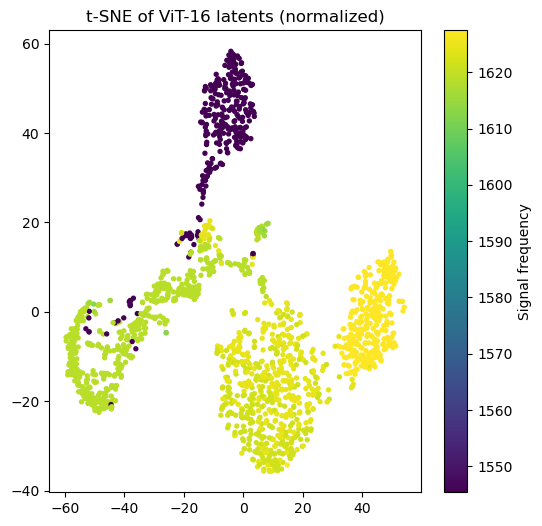

In [30]:
from sklearn.preprocessing import normalize

# Suppose Z_mid, Z_high are your [N×D] ViT outputs
Z_mid_norm  = normalize(latents_32d,  norm="l2", axis=1)

tsne_norm = TSNE(n_components=2, perplexity=30, random_state=42)
Z_tsne_norm = tsne.fit_transform(Z_mid_norm)

plt.figure(figsize=(6,6))
plt.scatter(Z_tsne_norm[:,0], Z_tsne_norm[:,1], c=freqs_array, cmap="viridis", s=8)
plt.colorbar(label="Signal frequency")
plt.title("t-SNE of ViT-16 latents (normalized)")
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

In [31]:
# from sklearn.cluster import DBSCAN, HDBSCAN

# # assume `mus` is your numpy array of shape (N, latent_dim)
# clusterer = HDBSCAN(min_cluster_size=100,
#                             min_samples=50,
#                             metric='cosine',
#                             cluster_selection_method='eom')
# labels = clusterer.fit_predict(latents_32d)   # array of length N: −1 = noise, ≥0 = cluster IDs

# # now you can e.g. visualize
# import matplotlib.pyplot as plt
# plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=labels, cmap="viridis", s=8)
# plt.colorbar(label="Cluster ID")
# plt.title("t-SNE from HDBSCAN")
# # plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
# plt.show()


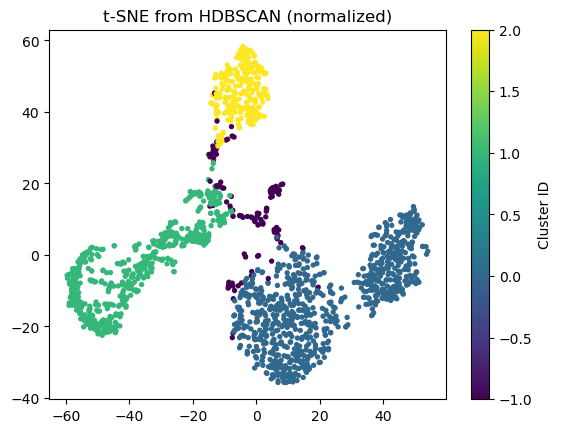

In [32]:
from sklearn.cluster import DBSCAN, HDBSCAN

# assume `mus` is your numpy array of shape (N, latent_dim)
clusterer = HDBSCAN(min_cluster_size=100,
                            min_samples=50,
                            metric='cosine',
                            cluster_selection_method='eom')
labels = clusterer.fit_predict(Z_mid_norm)   # array of length N: −1 = noise, ≥0 = cluster IDs

# now you can e.g. visualize
import matplotlib.pyplot as plt
plt.scatter(Z_tsne_norm[:,0], Z_tsne_norm[:,1], c=labels, cmap="viridis", s=8)
plt.colorbar(label="Cluster ID")
plt.title("t-SNE from HDBSCAN (normalized)")
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

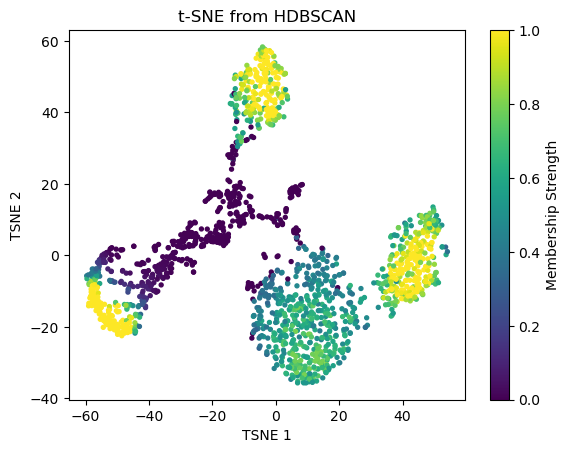

In [34]:
membership_strength = clusterer.probabilities_  # float in [0,1] for each sample
plt.scatter(Z_tsne_norm[:,0], Z_tsne_norm[:,1], c=membership_strength, cmap="viridis", s=8)
plt.colorbar(label="Membership Strength")
plt.title("t-SNE from HDBSCAN")
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2")
plt.show()

/tmp/ipykernel_1876076/346571066.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


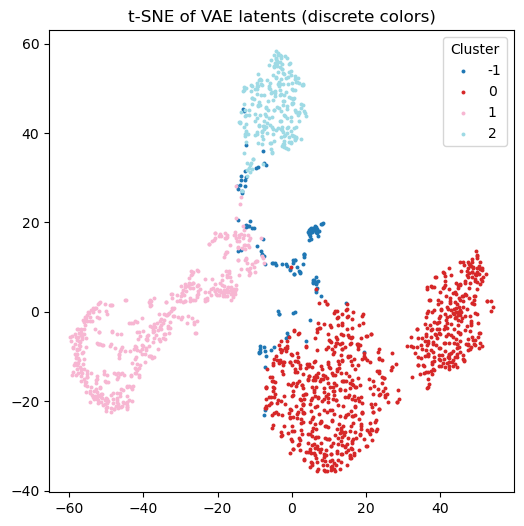

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_hex
from PIL import Image, ImageDraw
import random

# assume:
#   labels      — your HDBSCAN cluster labels, shape (N,)
#   dataset     — your YoloMaskDataset (with .images and .labels lists)
#   Z_tsne      — your t-SNE coords, shape (N,2)

# 1) Pick a discrete colormap (tab20 has 20 distinct colors)
unique_labels = np.unique(labels)
# remove noise if you like, or keep it
# unique_labels = unique_labels[unique_labels>=0]

# make a colormap with as many entries as distinct clusters
cmap = cm.get_cmap('tab20', len(unique_labels))

# map each cluster ID → a hex color
label2color = {}
for idx, lab in enumerate(unique_labels):
    # if lab == -1:
    #     label2color[lab] = "#808080"           # gray for noise
    # else:
        rgba               = cmap(idx)        # RGBA tuple in [0,1]
        label2color[lab]   = to_hex(rgba)     # convert to "#rrggbb"

# 2) (Optional) re‐plot your TSNE with the same discrete colors so you can check
plt.figure(figsize=(6,6))
for lab in unique_labels:
    mask = labels == lab
    plt.scatter(
        Z_tsne_norm[mask,0],
        Z_tsne_norm[mask,1],
        c=label2color[lab],
        label=f"{lab}",
        s=8,
        linewidths=0
    )
plt.legend(title="Cluster")
plt.title("t-SNE of VAE latents (discrete colors)")
plt.show()



In [59]:
# # 3) Now for each cluster, draw the full‐image bbox in that same color
# for lab in unique_labels:
#     # if lab == -1: 
#     #     continue   # skip noise if you don’t want to inspect it
#     idxs = np.where(labels==lab)[0]
#     sample_idxs = random.sample(idxs.tolist(), min(4, len(idxs)))

#     fig, axes = plt.subplots(1, len(sample_idxs), figsize=(4*len(sample_idxs),4))
#     fig.suptitle(f"Cluster {lab}", fontsize=16)

#     for ax, i in zip(axes, sample_idxs):
#         img_path = val_ds.images[i]
#         lbl_path = val_ds.labels[i]

#         img = Image.open(img_path).convert("RGB")
#         draw = ImageDraw.Draw(img)

#         # draw every bbox in that file
#         W, H = img.size
#         with open(lbl_path) as f:
#             for line in f:
#                 parts = line.strip().split()
#                 _, xc, yc, w, h = map(float, parts)
#                 x0 = (xc - w/2) * W; y0 = (yc - h/2) * H
#                 x1 = (xc + w/2) * W; y1 = (yc + h/2) * H
#                 draw.rectangle(
#                     [x0, y0, x1, y1],
#                     outline=label2color[lab],
#                     width=3
#                 )

#         ax.imshow(img)
#         ax.axis("off")

#     plt.tight_layout()
#     plt.show()


In [ ]:
# from matplotlib.backends.backend_pdf import PdfPages
# import math

# # Settings
# images_per_page = 16
# n_cols = 4
# n_rows = 4
# out_pdf = "cluster_all_paginated_clustersize_4.pdf"

# # Ensure label2color, labels, val_ds, and unique_labels are defined in the notebook context
# # label2color: dict mapping cluster_id -> hex color string
# # labels: numpy array of length N with cluster assignments
# # val_ds: dataset with .images and .labels lists
# # unique_labels: array of distinct cluster IDs

# with PdfPages(out_pdf) as pdf:
#     for lab in sorted(unique_labels):
#         # if lab == -1:
#         #     continue  # skip noise if desired

#         idxs = np.where(labels == lab)[0]
#         if len(idxs) == 0:
#             continue

#         num_pages = math.ceil(len(idxs) / images_per_page)
#         for page in range(num_pages):
#             start = page * images_per_page
#             end = start + images_per_page
#             page_idxs = idxs[start:end]

#             fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
#             axes = axes.flatten()
#             fig.suptitle(f"Cluster {lab} - Page {page + 1}/{num_pages}", fontsize=16)

#             # Draw each image with its bounding box
#             for ax, idx in zip(axes, page_idxs):
#                 img_path = val_ds.images[idx]
#                 lbl_path = val_ds.labels[idx]

#                 img = Image.open(img_path).convert("RGB")
#                 draw = ImageDraw.Draw(img)
#                 W, H = img.size

#                 with open(lbl_path) as f_lbl:
#                     for line in f_lbl:
#                         _, xc, yc, w, h = map(float, line.strip().split())
#                         x0 = (xc - w/2) * W
#                         y0 = (yc - h/2) * H
#                         x1 = (xc + w/2) * W
#                         y1 = (yc + h/2) * H
#                         draw.rectangle([x0, y0, x1, y1],
#                                        outline=label2color[lab],
#                                        width=3)

#                 ax.imshow(img)
#                 ax.axis("off")

#             # Hide any extra subplots if fewer than images_per_page
#             for ax in axes[len(page_idxs):]:
#                 ax.axis("off")

#             plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#             pdf.savefig(fig)
#             plt.close(fig)

# print(f"Saved PDF with all clusters to {out_pdf}")


Saved PDF with all clusters to cluster_all_paginated_clustersize_4.pdf


In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

# ─── CONFIG ────────────────────────────────────────────────────────────────────
cols = 6
rows = 6
per_page   = cols * rows
out_pdf    = "all_crops_by_cluster_i_s154_with_deltas_vit_100_cosine.pdf"

# total time span of each spectrogram (in seconds)
time_window_seconds = 5*60

# assume these are defined:
#  • labels, val_ds.images, val_ds.labels, label2color

unique_labels = sorted(set(labels.tolist()))

with PdfPages(out_pdf) as pdf:
    for lab in unique_labels:
        idxs = np.where(labels == lab)[0]
        if len(idxs) == 0:
            continue

        n_pages = math.ceil(len(idxs) / per_page)
        for p in range(n_pages):
            start     = p * per_page
            page_idxs = idxs[start : start + per_page]

            fig, axes = plt.subplots(rows, cols,
                                     figsize=(cols * 2.5, rows * 2.5))
            fig.suptitle(f"Cluster {lab} — page {p+1}/{n_pages}", 
                         fontsize=16)

            for ax, idx in zip(axes.flatten(), page_idxs):
                # load crop → PIL
                img = Image.open(test_ds.images[idx]).convert("L")

                # read the single YOLO box
                lbl_path = test_ds.labels[idx]
                with open(lbl_path) as f:
                    cls, xc, yc, w_norm, h_norm = map(float, f.readline().split())

                # — pull per-image freq_min / freq_max from the filename —
                fname = os.path.basename(test_ds.images[idx])
                m = re.search(r"f_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)", fname)
                if not m:
                    raise ValueError(f"Could not parse freq range from {fname}")
                freq_max_img = float(m.group(1))
                freq_min_img = float(m.group(2))
                freq_range_img = freq_max_img - freq_min_img

                # compute physical sizes
                time_size = h_norm * time_window_seconds    # seconds
                freq_size = w_norm * freq_range_img  # MHz

                # draw image and colored frame
                ax.imshow(img)
                ax.axis("off")
                for spine in ax.spines.values():
                    spine.set_edgecolor(label2color.get(lab, "#000000"))
                    spine.set_linewidth(2)

                # set title to include t and f
                ax.set_title(
                    f"C{lab} | t={time_size:.1f}s | f={freq_size:.1f}MHz\n C={freq_min_img + freq_range_img * xc:.1f}MHz",
                    color='k',
                    weight='bold',
                    fontsize=10,
                )

            # blank out unused axes
            for ax in axes.flatten()[len(page_idxs):]:
                ax.axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig(fig)
            plt.close(fig)

print(f"Saved PDF with per box t/f annotations to {out_pdf}")


Saved PDF with per box t/f annotations to all_crops_by_cluster_i_s154_with_deltas_vit_100_cosine.pdf


In [ ]:
# import math
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from PIL import Image

# # 1) Make sure you have these in your environment:
# #    • labels:     numpy array of length N with cluster IDs (-1 for noise)
# #    • full_ds:    your dataset, so that full_ds[i] returns (crop_tensor, …)
# #    • label2color: dict mapping each cluster ID → hex color (e.g. "#1f77b4")

# # 2) Derive unique cluster IDs
# unique_labels = sorted(set(labels.tolist()))

# # 3) Grid dimensions
# cols = 6
# rows = 6
# per_page = cols * rows
# out_pdf = "all_crops_by_cluster_i_s154.pdf"

# with PdfPages(out_pdf) as pdf:
#     for lab in unique_labels:
#         # if lab == -1:
#         #     continue  # skip noise if you’d like

#         idxs = np.where(labels == lab)[0]
#         # if len(idxs) == 0:
#         #     continue

#         n_pages = math.ceil(len(idxs) / per_page)
#         for p in range(n_pages):
#             start = p * per_page
#             end   = start + per_page
#             page_idxs = idxs[start:end]

#             fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
#             fig.suptitle(f"Cluster {lab} — page {p+1}/{n_pages}", fontsize=16)

#             for ax, idx in zip(axes.flatten(), page_idxs):
#                 # grab the crop tensor and convert to PIL
#                 crop_tensor = val_ds[idx][0]
#                 arr = crop_tensor.permute(1,2,0).cpu().numpy()
#                 arr = (arr * 255).astype(np.uint8)
#                 img = Image.fromarray(arr)

#                 ax.imshow(img)
#                 ax.axis("off")

#                 # color the frame to match cluster
#                 for spine in ax.spines.values():
#                     spine.set_edgecolor(label2color.get(lab, "#000000"))
#                     spine.set_linewidth(2)
#                 ax.set_title(f"C{lab}", color=label2color.get(lab, "#000000"), fontsize=8)

#             # blank out unused subplots
#             for ax in axes.flatten()[len(page_idxs):]:
#                 ax.axis("off")

#             plt.tight_layout(rect=[0,0.03,1,0.95])
#             pdf.savefig(fig)
#             plt.close(fig)

# print(f"▶️ Saved all crops to {out_pdf}")




▶️ Saved all crops to all_crops_by_cluster_i_s154.pdf


Note: you may need to restart the kernel to use updated packages.
Confusion matrix (rows=true, cols=predicted):
[[611  41]
 [  0 338]]

Classification report:
               precision    recall  f1-score   support

     1545 MHz       1.00      0.94      0.97       652
1610-1620 MHz       0.89      1.00      0.94       338

     accuracy                           0.96       990
    macro avg       0.95      0.97      0.96       990
 weighted avg       0.96      0.96      0.96       990



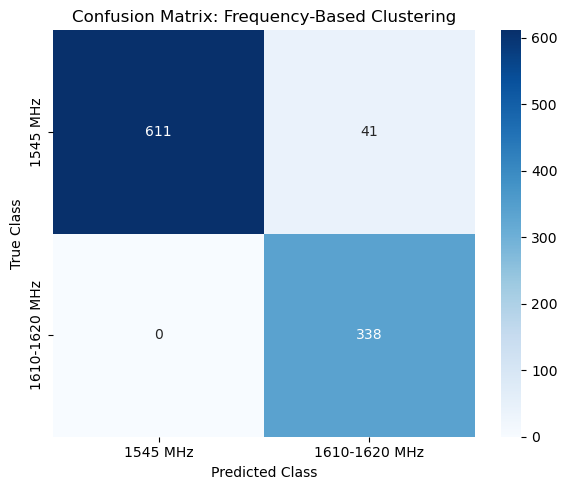

In [ ]:
# %pip install seaborn
# import seaborn as sns
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report

# # ─── assume these are already in your namespace ────────────────────────────────
# # labels      : np.ndarray of shape (N,) with HDBSCAN cluster IDs (−1=noise)
# # freqs_array : np.ndarray of shape (N,) with the extracted f_… values

# # 1) (Optional) ignore noise points
# mask        = labels >= 0
# labels_filt = labels[mask]
# freqs_filt  = freqs_array[mask]

# # 2) Build true frequency‐based classes
# #    class 1 = in 1610–1620 MHz, else class 0 (i.e., ~1545 MHz)
# true_classes = np.where(
#     (freqs_filt >= 1610) & (freqs_filt <= 1620),
#     1,
#     0
# )

# # 3) Map each cluster ID to the class whose mean freq it sits in
# cluster_ids    = np.unique(labels_filt)
# cluster_means  = {cid: freqs_filt[labels_filt == cid].mean()
#                   for cid in cluster_ids}

# cluster_to_cls = {}
# for cid, mean_f in cluster_means.items():
#     if 1610 <= mean_f <= 1620:
#         cluster_to_cls[cid] = 1
#     else:
#         cluster_to_cls[cid] = 0

# # 4) Build predicted classes from cluster assignments
# pred_classes = np.array([cluster_to_cls[c] for c in labels_filt])

# # 5) Compute & print the confusion matrix
# cm = confusion_matrix(true_classes, pred_classes, labels=[0,1])
# print("Confusion matrix (rows=true, cols=predicted):")
# print(cm)

# # 6) (Optional) More detailed metrics
# print("\nClassification report:")
# print(classification_report(true_classes, pred_classes, target_names=[
#     "1545 MHz",
#     "1610-1620 MHz"
# ]))

# # 1) Compute the 2×2 matrix
# cm = confusion_matrix(true_classes, pred_classes, labels=[0, 1])

# # 2) Plot with Seaborn
# plt.figure(figsize=(6, 5))
# ax = sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=["1545 MHz", "1610-1620 MHz"],
#     yticklabels=["1545 MHz", "1610-1620 MHz"]
# )
# ax.set_xlabel("Predicted Class")
# ax.set_ylabel("True Class")
# ax.set_title("Confusion Matrix: Frequency-Based Clustering")

# plt.tight_layout()
# plt.show()


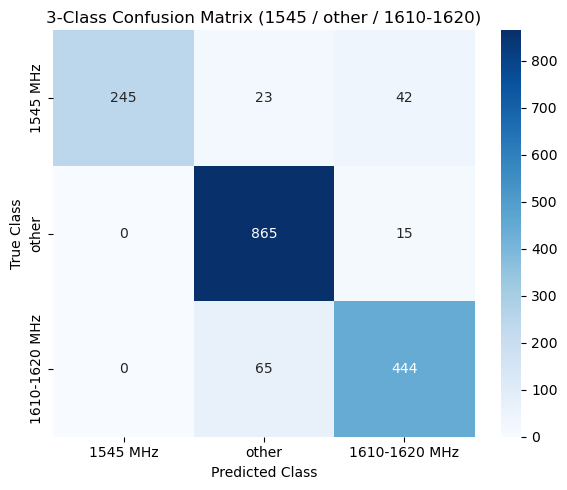

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) BUILD TRUE 3-CLASS VECTOR ────────────────────────────────────────────
# default everything to “other” (1)
true3 = np.full(freqs_array.shape, 1, dtype=int)

# class “1545” → 0
mask1545 = (freqs_array >= 1545.0) & (freqs_array < 1546.0)
true3[mask1545] = 0

# class “1610-1620” → 2
mask1610 = (freqs_array >= 1610) & (freqs_array <= 1620)
true3[mask1610] = 2


# ─── 2) MAP EACH CLUSTER → {0,1,2} ───────────────────────────────────────────
cluster_ids   = np.unique(labels)
cluster_means = {
    cid: freqs_array[labels == cid].mean()
    for cid in cluster_ids
}

cluster_to_cls3 = {}
tol = 1.0
for cid, mean_f in cluster_means.items():
    if cid == -1:
        # noise → “other” (1)
        cluster_to_cls3[cid] = 1
    elif abs(mean_f - 1545) <= tol:
        cluster_to_cls3[cid] = 0
    elif 1610 <= mean_f <= 1620:
        cluster_to_cls3[cid] = 2
    else:
        cluster_to_cls3[cid] = 1

# build predicted‐class array 
pred3 = np.array([cluster_to_cls3[c] for c in labels])


# ─── 3) COMPUTE & PLOT 3×3 CONFUSION MATRIX ─────────────────────────────────
cm3 = confusion_matrix(true3, pred3, labels=[0,1,2])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm3,
    annot=True, fmt="d",
    cmap="Blues",
    xticklabels=["1545 MHz","other","1610-1620 MHz"],
    yticklabels=["1545 MHz","other","1610-1620 MHz"],
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("3-Class Confusion Matrix (1545 / other / 1610-1620)")
plt.tight_layout()
plt.show()



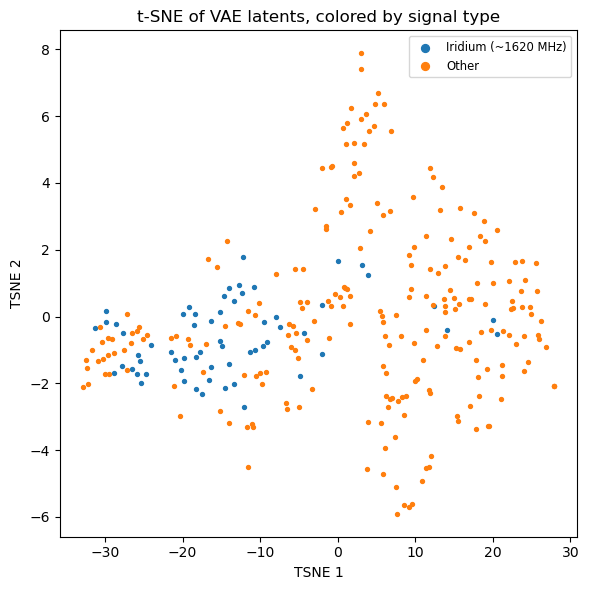

In [23]:
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(mus_array)

# 1) Assign each point to a signal type based on its frequency
labels = []
for f in freqs_array:
    if abs(f - 1575) < 10:           # within ±10 MHz of 1575
        labels.append("GPS (~1575 MHz)")
    elif abs(f - 1620) < 10:         # within ±10 MHz of 1620
        labels.append("Iridium (~1620 MHz)")
    else:
        labels.append("Other")

labels = np.array(labels)

# 2) Plot each category separately for discrete coloring + legend
plt.figure(figsize=(6,6))
for lab in np.unique(labels):
    mask = (labels == lab)
    plt.scatter(
        Z_tsne[mask, 0],
        Z_tsne[mask, 1],
        label=lab,
        s=8
    )

plt.title("t-SNE of VAE latents, colored by signal type")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(markerscale=2, fontsize="small", frameon=True)
plt.tight_layout()
plt.show()


# # 4b) UMAP embedding
# um = umap.UMAP(n_components=2, random_state=42)
# Z_umap = um.fit_transform(mus)

# plt.figure(figsize=(6,6))
# plt.scatter(Z_umap[:,0], Z_umap[:,1], c=freqs, cmap="plasma", s=8)
# plt.colorbar(label="Signal frequency")
# plt.title("UMAP of VAE latents colored by f_")
# plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
# plt.show()